In [1]:
#######################################################################################
# Python code to take data with FieldFox Handheld portable combination analyzer       #
# Requires VISA installed on controlling PC, 'http://pyvisa.sourceforge.net/pyvisa/'  #
# Keysight IO Libraries 18.1.22x 32-Bit Keysight VISA (as primary)                    #
# Anaconda Python 4.4.0 32 bit                                                        #
# pyvisa 3.6.x                                                                        #
# Currently using a mini-USB connection                                               #
#######################################################################################


In [3]:
import pyvisa
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
# Open a VISA resource manager pointing to the installation folder for the Keysight Visa libraries.
rm = pyvisa.ResourceManager('/opt/keysight/iolibs/libktvisa32.so')
# Based on the resource manager, open a session to a specific VISA resource string as provided via Keysight 
# Connection Expert
myFieldFox = rm.open_resource("USB0::0x2A8D::0x5C18::MY61262579::0::INSTR") 

In [4]:
# Define Error Check Function
def Errcheck():
    myError = []
    ErrorList = myFieldFox.query("SYST:ERR?").split(',')
    Error = ErrorList[0]
    if int(Error) == 0:
        print("+0, No Error!")
    else:
        while int(Error)!=0:
            print("Error #: " + ErrorList[0])
            print("Error Description: " + ErrorList[1])
            myError.append(ErrorList[0])
            myError.append(ErrorList[1])
            ErrorList = myFieldFox.query("SYST:ERR?").split(',')
            Error = ErrorList[0]
            myError = list(myError)
    return myError

In [5]:
def set_initial_params(output_pow, points, avg_sweep, myFieldFox):
    """ 
    output_pow = str; +/- output power in dB, ex. '-60'
    points = str; number of points per sweep
    avg_sweep = str; average number of sweeps
    """
    ## Set some initial parameters, query *IDN?
    myFieldFox.timeout = 10000 #Set Timeout - 10 seconds
    myFieldFox.write("*CLS") # Clear the event status registers and empty the error queue
    myFieldFox.write("*IDN?") # Query identification string *IDN?
    print("FieldFox Version:" + myFieldFox.read())
    # Preset the FieldFox and wait for operation complete via the *OPC?, i.e. the operation complete query.
    myFieldFox.write("SYST:PRES;*OPC?")
    print("Preset complete, *OPC? returned : " + myFieldFox.read())
    myFieldFox.write("INST:SEL 'NA';*OPC?") # Set mode to Network Analyzer and wait for operation complete via the *OPC?
    myFieldFox.read()
    myFieldFox.write('SOUR:POW '+output_pow) # Set the output power to -60 dB
    myFieldFox.write("CALC:PAR:DEF S21") # Measure the S21 parameter
    ## Set the start and stop frequency and print out the values
    myFieldFox.write("FREQ:STAR MIN") # Set the starting frequency to a miminum
    myFieldFox.write("SENS:FREQ:START?") # Query to make sure it is working
    startFreq = myFieldFox.read().strip('\n') # Save the starting frequency
    myFieldFox.write("FREQ:STOP 500e6") # Set the stopping frequency to 500 MHz
    myFieldFox.write("SENS:FREQ:STOP?") # Query
    stopFreq = myFieldFox.read().strip('\n') # Save stop value
    print("FieldFox start frequency = " + startFreq + ", stop frequency = " + stopFreq)
    myFieldFox.write("SWE:POIN "+points) # Set number of points in a sweep
    myFieldFox.write("SENS:SWE:POIN?") # Query to make sure it's set correctly
    numPoints = myFieldFox.read().strip('\n') # Save the number of points in a sweep
    print("Number of trace points = " + numPoints)
    myFieldFox.write("AVER:COUNt "+avg_sweep) # Set averaging to 50 sweeps
    myFieldFox.write("AVER:CLE") # Clear sweeps
    freqs = np.linspace(int(startFreq), int(stopFreq), int(numPoints)) # Create an array of freqs
    
    return freqs, numPoints

In [6]:
def take_data(no_of_traces, numPoints, myFieldFox):

    no_of_traces = 10 # How many traces you want to take
    trace_array = np.zeros((no_of_traces, int(numPoints)))

    for i in range(no_of_traces):
        time.sleep(1) # Wait for all sweeps to occur
        # Once you've waited a while, hold
        myFieldFox.write("INIT:CONT 0;*OPC?") # Hold
        myFieldFox.read()
        myFieldFox.write("INIT:IMMediate;*OPC?") # Trigger on a measurement
        myFieldFox.read()
        myFieldFox.write("CALC:SMO 1") # Apply smoothing I think
        myFieldFox.write("CALC:DATA:FDATa?") # Read data from selected trace
        trace = myFieldFox.read() # Save that data
        # Clean up the data, save the trace as an array of floats
        trace = trace.split(',')
        for m in range(len(trace)):
            if '\n' in trace[m]:
                trace[m].strip('\n')
            trace[m] = float(trace[m])
        trace = np.array(trace)
        trace_array[i] = trace
        print("%d / %d traces complete..."%(i, no_of_traces))
        myFieldFox.write("INIT:CONT ON") # Continue sweeping, run in continuous mode
        myFieldFox.write("AVER:CLE") # Reset your sweep
        
    return trace_array

In [12]:
def plot_data(freqs, data, title):
    """
    freqs = 1-D array; Range of frequencies covered by FieldFox
    data = array; Data taken with FieldFox (size = number of traces x number of points)
    title = str; Save this file!
    """
    plt.figure(figsize=(10,8))
    for trace in data:
        plt.plot(freqs, trace)
    plt.xlabel('Frequency (MHz)', fontsize=22)
    plt.ylabel('dB',fontsize=22)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(title+'.png')
    plt.show()
    
    return

In [11]:
# Call and print error check results
print(Errcheck())

+0, No Error!
[]


In [8]:
freqs, numPoints = set_initial_params('-60', '450', '50', myFieldFox)
trace_data = take_data(10, numPoints, myFieldFox)
plot_data(freqs, trace_array, 'LNA_10628')

FieldFox Version:Keysight Technologies,N9913B,MY61262579,A.12.20

Preset complete, *OPC? returned : 1

FieldFox start frequency = 30000, stop frequency = 500000000
Number of trace points = 450
0 / 10 traces complete...
1 / 10 traces complete...
2 / 10 traces complete...
3 / 10 traces complete...
4 / 10 traces complete...
5 / 10 traces complete...
6 / 10 traces complete...
7 / 10 traces complete...
8 / 10 traces complete...
9 / 10 traces complete...


NameError: name 'trace_array' is not defined

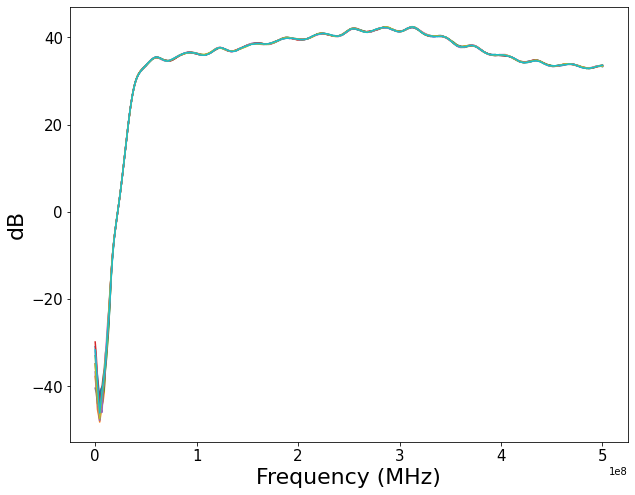

In [13]:
plot_data(freqs, trace_data, 'LNA_10628')

In [2]:
import h5py

In [4]:
with h5py.File('/home/radioantenna/kansas_data/losses/014_average.hdf5', 'r') as f:
    freqs = np.array(f['freq_vals'])
    traces = np.array(f['trace_data'])
    power = np.array(f['power_val'])
    print(f.keys())

<KeysViewHDF5 ['freq_vals', 'power_val', 'trace_data']>


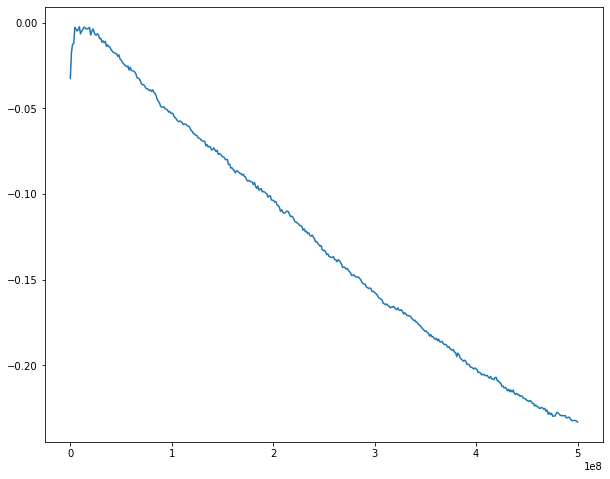

In [5]:
plt.figure(figsize=(10,8))
for trace in traces:
    plt.plot(freqs, trace)

In [6]:
f.close()

In [26]:
file = open('/home/radioantenna/001_statistics.txt') 

In [27]:
file.readline()

'-2.218154109999999957e+00 2.992401263999999728e-01 -1.567607558000000123e-01 9.513960863999999518e-01 -4.880019039999999864e-01 4.970793329999999982e-02 -1.283993286000000067e+00 1.973882783999999946e+00 -7.686014577999999986e-01 -1.213702719999999902e+00 -3.344605169999999905e+00 -8.470167177999999852e-01 -2.198328635999999836e+00 -2.154479415999999981e-01 -2.865232965999999770e-01 -6.669882355999999790e-01 -4.783732029999999968e-02 -8.339183382000000533e-01 1.466456411000000015e-01 1.298143765000000061e+00 -1.947839960000000148e-02 1.520287345000000123e-01 4.749553318000000246e+00 -6.505430819999999392e-02 -1.085737960999999974e+00 -7.622748791000000246e-01 -5.797427940999999585e-01 7.086341143000000065e-01 -2.523218838000000019e+00 -1.375586066000000107e+00 -1.506522166000000107e+00 -5.561983928999999494e-01 1.724373117999999927e-01 -6.721324739999999520e-02 -2.251191566999999782e+00 -1.875884704000000125e-01 2.413122692000000125e-01 -1.518983477999999998e+00 -1.428668881999999973e

In [36]:
t = 50

while t:
    mins, secs = divmod(t, 60)
    timer = '{:02d}:{:02d}'.format(mins, secs)
    print(timer, end="\r")
    time.sleep(1)
    t -= 1